In [4]:
# Ethan Goolish, Jan 2020.
# Processes raw FRET data into binned format.

In [5]:
# Import Needed Packages

import pandas as pd
import numpy as np


Original Data
   Microtime  Channel  Nanotime        ts  ts_int
0     7297.0      3.0    2032.0  0.729781       0
1    11991.0      3.0     156.0  1.199131       1
2    16075.0      4.0    1134.0  1.607571       1
3    24444.0      3.0      84.0  2.444455       2
4    26971.0      4.0     806.0  2.697184       2


Final Output:
        ts_start  n_accept  n_donor  effi
0          0.000         1        0   1.0
1          0.001         1        1   0.5
2          0.002         2        2   0.5
3          0.003         0        1   0.0
4          0.004         0        2   0.0
...          ...       ...      ...   ...
179984   179.984         0        1   0.0
179985   179.985         0        0   NaN
179986   179.986         0        0   NaN
179987   179.987         0        0   NaN
179988   179.988         1        0   1.0

[179989 rows x 4 columns]



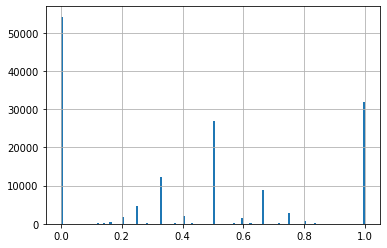

In [48]:
# Define which file to bin data from
filename = 'noprotein.txt'
filepath = 'fret_data/'

fileloc = filepath + filename

# Size of bin = 1/precision seconds.
precision = 1000 # default = 100 

# Read in the file to a pandas data frame
df = pd.read_csv(fileloc, sep = "\t", skiprows=2, header=None)
df.columns = ['Microtime', 'Channel', 'Nanotime']

# Find TS Labels:
# From the github page "https://github.com/cgoolsby/smFRET_exploration/blob/master/notebooks/Initial%20Exploration.ipynb"
# We have the following description:
# " To find the timestamp, simply sum
#   ts = (column1 * e-7 + column2 * 3.2e-11)""
#
# Note: I believe this gives you time in seconds, which you then multiply by "precision"
#       to get bins of size "precision". Index i corresponds to the time segment given by
#       (i/precision, (i+1)/precision). 
#
# Store this in column 'ts'
# Round down to nearest int via cast to bin, store in column 'ts_int'
df['ts'] = ((df['Microtime']*1.0000216e-07 + df['Nanotime']*3.2e-11)*precision) 
df['ts_int'] = df['ts'].astype('int64')

# Print the Full DataFrame
print()
print("Original Data")
print(df.head())
print()

# Split DataFrame into Acceptor and Donor
accept_df = df[np.isclose(df['Channel'], 3)]
donor_df = df[np.isclose(df['Channel'], 4)]

# Put all the pieces together in the final dataframe
# ts_start is the start of the time segment in seconds
# n_accept is the number of acceptor in the time segment
# n_donor is the number of donor in the time segment
# effi is the calculated efficiency, given by n_accept/(n_accept + n_donor)
ret = pd.DataFrame(data = {'ts_start' : np.arange(df['ts_int'].max() + 1)})
ret['n_accept'] = pd.value_counts(accept_df['ts_int']).reindex(ret['ts_start'], fill_value = 0)
ret['n_donor'] = pd.value_counts(donor_df['ts_int']).reindex(ret['ts_start'], fill_value = 0)
ret['ts_start'] /= precision
ret['effi'] = ret['n_accept']/(ret['n_accept'] + ret['n_donor'])


# Draws a Histogram, prints the dataframe, then writes to a csv file.
ret['effi'].hist(bins=150)
print()
print("Final Output:")
print(ret)
print()
newfileloc = filepath + 'binned_ms_' + filename
ret.to_csv(newfileloc, index=False)